# Modelo de previsão de diabetes 

![diabetes](files/img/header.jpeg)

## Índice
1. [Introdução](#introducao)
2. [Sobre os dados](#sobre)
3. [Avaliação do modelo](#avaliacao)

## Introdução <a name="introdução"></a>

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado**.

Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). 


## Sobre os dados <a name="sobre"></a>

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

* Pregnancies: Number of times pregnant

* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test

* BloodPressure: Diastolic blood pressure (mm Hg)

* SkinThickness: Triceps skin fold thickness (mm)

* Insulin: 2-Hour serum insulin (mu U/ml)

* BMI: Body mass index (weight in kg/(height in m)^2)

* DiabetesPedigreeFunction: Diabetes pedigree function

* Age: Age (years)

* Outcome: Class variable (0 or 1)



## Avaliação do modelo <a name="avaliacao"></a>

A métrica que utilizaremos para avaliar o modelo será a **acurácia**. Compararemos nossos resultados com um modelo empírico baseado na taxa de glicose. 

## Importando e explorando os dados

In [18]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [19]:
data = pd.read_csv("data/diabetes.csv")

In [20]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [23]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos em {col}")

111 valores nulos em Pregnancies
5 valores nulos em Glucose
35 valores nulos em BloodPressure
227 valores nulos em SkinThickness
374 valores nulos em Insulin
11 valores nulos em BMI
0 valores nulos em DiabetesPedigreeFunction
0 valores nulos em Age
500 valores nulos em Outcome


Valores nulos de Glucose, BloodPressure, SkinThickness, Insulin e BMI são na verdade **NaN**. Vamos inspecionar um pouco mais as colunas de Glucose e BMI:

In [24]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.7,0.140,22,0
182,1,0,74,20,23,27.7,0.299,21,0
342,1,0,68,35,0,32.0,0.389,22,0
349,5,0,80,32,0,41.0,0.346,37,1
502,6,0,68,41,0,39.0,0.727,41,1


In [25]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em BMI são de pacientes não-diabéticos.

## EDA

In [27]:
# Plotting variables distribution without NaN

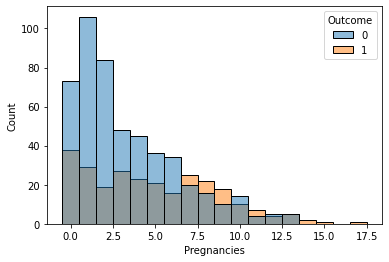

In [28]:
_ = sns.histplot(data, x="Pregnancies", hue="Outcome", discrete=True)

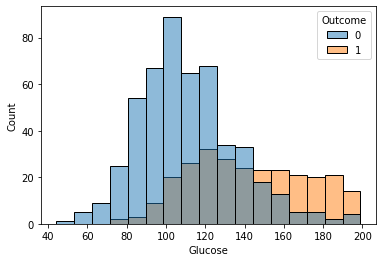

In [29]:
_ = sns.histplot(data[data["Glucose"] != 0], x="Glucose", hue="Outcome")

Make a baseline model: if Glucose >

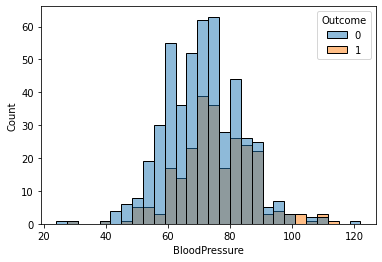

In [30]:
_ = sns.histplot(data[data["BloodPressure"] != 0], x="BloodPressure", hue="Outcome")

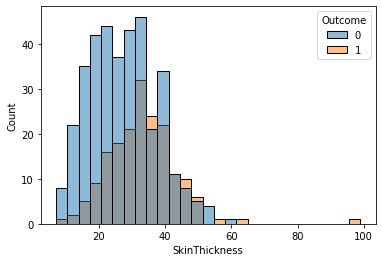

In [31]:
_ = sns.histplot(data[data["SkinThickness"] != 0], x="SkinThickness", hue="Outcome")

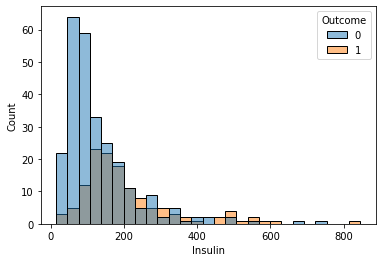

In [32]:
_ = sns.histplot(data[data["Insulin"] != 0], x="Insulin", hue="Outcome")

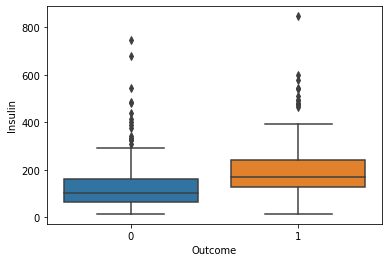

In [33]:
_ = sns.boxplot(data=data[data["Insulin"] != 0], x="Outcome", y="Insulin")

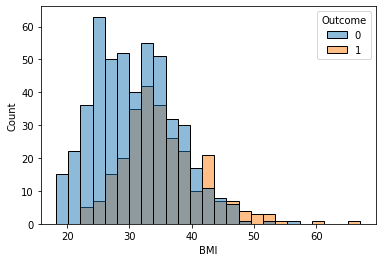

In [34]:
_ = sns.histplot(data[data["BMI"] != 0], x="BMI", hue="Outcome")

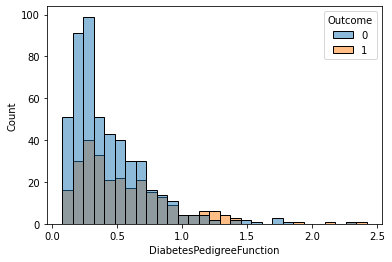

In [35]:
_ = sns.histplot(data, x="DiabetesPedigreeFunction", hue="Outcome")

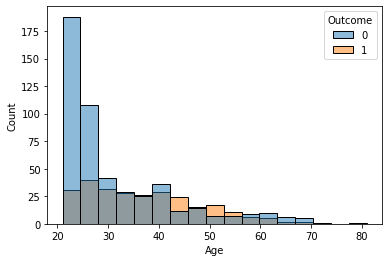

In [36]:
_ = sns.histplot(data, x="Age", hue="Outcome")

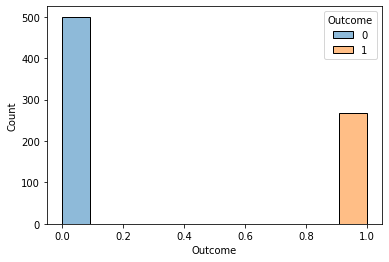

In [37]:
_ = sns.histplot(data, x="Outcome", hue="Outcome")

In [ ]:
# Our data is not balanced: almost twice of the instances are not diabetic.

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
Name: Outcome, dtype: float64


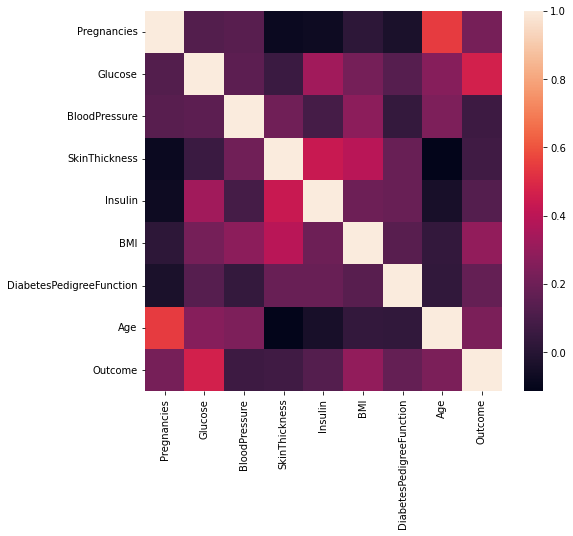

In [59]:
corr_matrix = data.corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

plt.figure(figsize=(8,7))
_ = sns.heatmap(data=corr_matrix)

# Baseline ML

In [9]:
# Creating the features and target datasets

X = data.drop("Outcome", axis=1)
y = data["Outcome"]

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [10]:
# Train and test datasets

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, random_state=42)

In [11]:
# Defining some metrics report functions

def cross_val_report(estimator, X_train, y_train):
    cv_score = cross_val_score(estimator, X_train, y_train, cv=3, scoring="accuracy")
    cv_mean_score = cv_score.mean()
    print(f"Mean accuracy score is: {np.round(cv_mean_score, 4)}")
    
def metrics_report(y_train, y_pred):
    accuracy = np.round(accuracy_score(y_train, y_pred), 4)
    precision = np.round(precision_score(y_train, y_pred), 4)
    recall = np.round(recall_score(y_train, y_pred), 4)
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")

In [12]:
# Basic treatment: scaling

std_scaler = StandardScaler()
X_train_tr = std_scaler.fit_transform(X_train)

In [23]:
# Logistic Regression

log_clf = LogisticRegression()
log_clf.fit(X_train_tr, y_train)

cross_val_report(log_clf, X_train_tr, y_train)

Mean accuracy score is: 0.7622


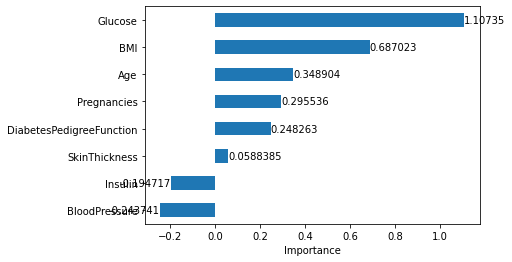

In [24]:
# Make an importance plot

# Get importances and labels
feat_importances = list(log_clf.coef_[0])
labels = list(X.columns)

# Creating a df
importance_df = pd.DataFrame({"importance":feat_importances}, index=labels)

# Sort
importance_df.sort_values(by="importance", inplace=True, ascending=True)

# Color
importance_df["positive"] = importance_df["importance"] > 0

# Plot
sns_plot = importance_df.plot(kind='barh', legend=False)
plt.xlabel("Importance")
plt.bar_label(sns_plot.containers[0])
plt.show()

In [25]:
# Decision tree classifier

tree_clf = DecisionTreeClassifier(max_depth=3, max_features=8, random_state=42)
tree_clf.fit(X_train_tr, y_train)

cross_val_report(tree_clf, X_train_tr, y_train)

Mean accuracy score is: 0.7377


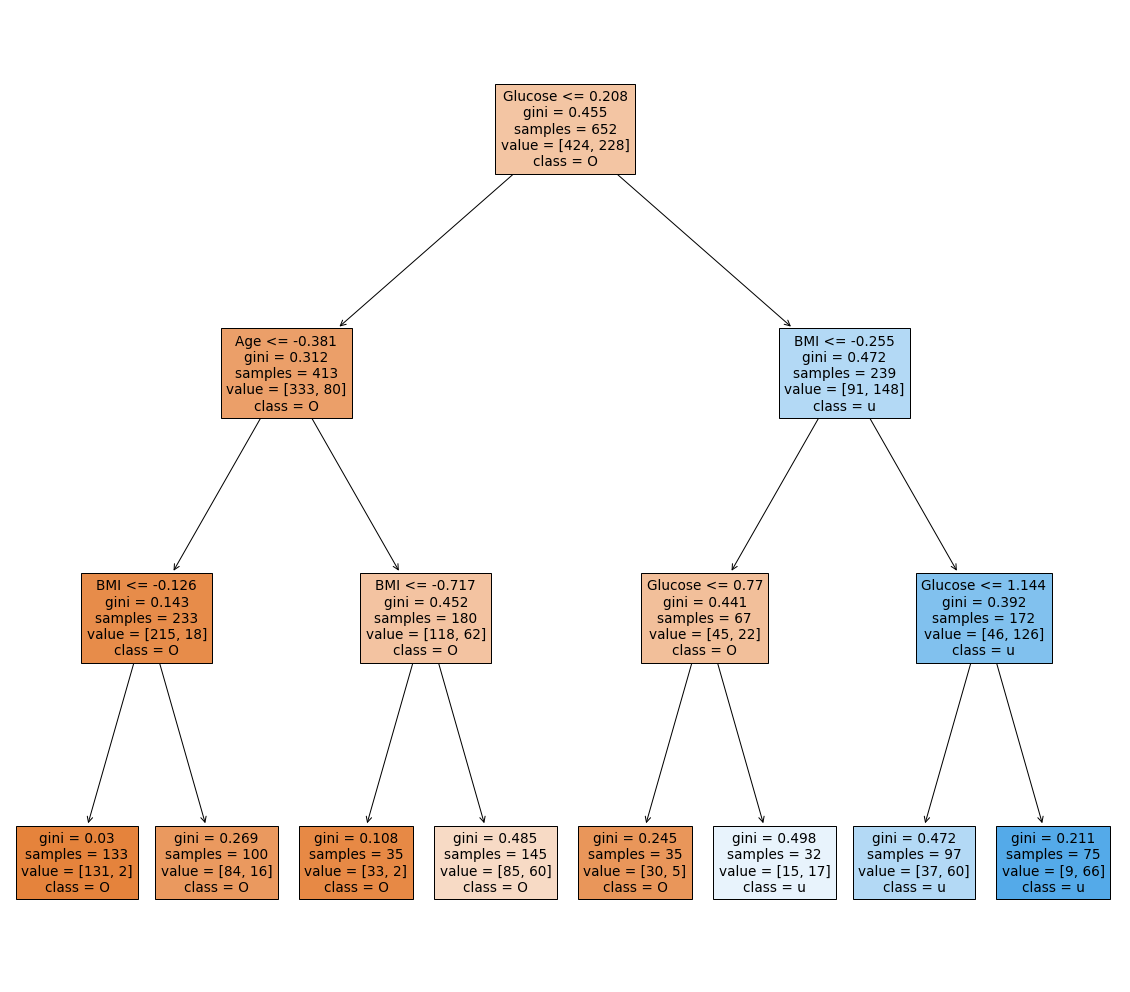

In [26]:
# Plotting tree

fig = plt.figure(figsize=(20,18))
_ = tree.plot_tree(tree_clf, feature_names=X.columns,  
                   class_names="Outcome",
                   filled=True)

# Data treatment

In [ ]:
# Treating outliers

In [34]:
def outlier_thresholds(df, feature):
    """
    Returns low and high limits for a feature from a dataframe.
    iqr (interquantile range) is defined here as the range between 10%-90% of the data.
    Thresholds will be streched of 1.5 * iqr from the quantiles.
    """
    quantile1 = df[feature].quantile(0.1)
    quantile3 = df[feature].quantile(0.9)
    iqr = quantile3 - quantile1
    high_limit = quantile3 + 1.5 * iqr 
    low_limit = quantile1 - 1.5 * iqr
    return low_limit, high_limit

outlier_thresholds(X, "Glucose")
    

(-38.0, 290.0)

In [30]:
X["Glucose"].quantile(0.10)

85.0

In [ ]:
# Discretizing variables

In [29]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, random_state=42)

In [30]:
X_train = X_train.drop(["SkinThickness", "BloodPressure", "Insulin", "DiabetesPedigreeFunction"] , axis=1)

In [31]:
X_train

,Pregnancies,Glucose,BMI,Age
227,3,162,37.2,24
168,4,110,31.9,29
513,2,91,27.3,22
7,10,115,35.3,29
196,1,105,24.3,21
...,...,...,...,...
71,5,139,28.6,26
106,1,96,22.4,27
270,10,101,45.6,38
435,0,141,42.4,29


In [32]:
# Restoring NaN to Glucose and BMI

X_train[["Glucose", "BMI"]] = X_train[["Glucose", "BMI"]].replace(0, np.nan)

In [33]:
# New treatment

knn_imputer = KNNImputer()
std_scaler = StandardScaler()

tr_steps = [("imputer", knn_imputer), ("scaler", std_scaler)]
tr_pipeline = Pipeline(tr_steps)

X_train_tr = tr_pipeline.fit_transform(X_train)

In [34]:
# Random Forest

forest_clf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=42)
forest_clf.fit(X_train_tr, y_train)

# Cross-validation

cross_val_report(forest_clf, X_train_tr, y_train)

Mean accuracy score is: 0.773


In [35]:
# Hyperparameter tunning

forest_clf = RandomForestClassifier(n_estimators=500, random_state=42)
param_grid = {"max_features":[1,2,3,4], "max_depth":[2,3,4,5]}
grid_search_cv = GridSearchCV(forest_clf, param_grid, scoring="accuracy", cv=3)
grid_search_cv.fit(X_train_tr, y_train)

print(f"Best score was {grid_search_cv.best_score_} with parameters {grid_search_cv.best_params_}.")

Best score was 0.7791118815090404 with parameters {'max_depth': 5, 'max_features': 1}.


In [36]:
# Testing on the test sample and verifying other metrics

# Treatment

X_validation = X_validation.drop(["SkinThickness", "BloodPressure", "Insulin", "DiabetesPedigreeFunction"] , axis=1)
X_validation[["Glucose", "BMI"]] = X_validation[["Glucose", "BMI"]].replace(0, np.nan)
X_validation_tr = tr_pipeline.fit_transform(X_validation)

In [37]:
forest_clf = RandomForestClassifier(n_estimators=500, max_depth=5, max_features=1, random_state=42)
forest_clf.fit(X_train_tr, y_train)
y_pred = forest_clf.predict(X_validation_tr)

In [38]:
metrics_report(y_validation, y_pred)

Accuracy score: 0.7931
Precision score: 0.7105
Recall score: 0.675


In [39]:
# Do a cross val predict for other metrics
y_scores = cross_val_predict(forest_clf, X_train_tr, y_train, cv=3, method="predict_proba")[:,1]

In [40]:
roc_auc_score(y_train, y_scores)

0.846025736511089

In [41]:
fpr, tpr, thr = roc_curve(y_train, y_scores)

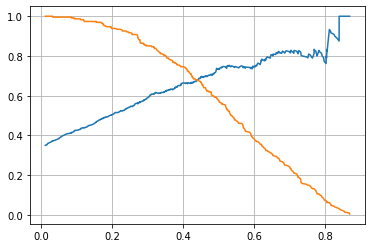

In [42]:
precision, recall, thresholds = precision_recall_curve(y_train, y_scores)

plt.plot(thresholds, precision[:-1])
plt.plot(thresholds, recall[:-1])
plt.grid()
plt.show()

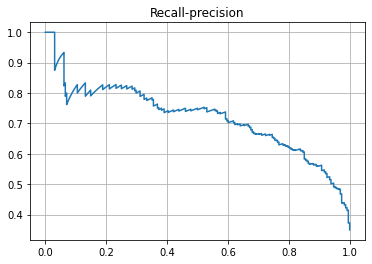

In [43]:
# Recall-precision curve

plt.plot(recall, precision)
plt.grid()
plt.title("Recall-precision")
plt.show()

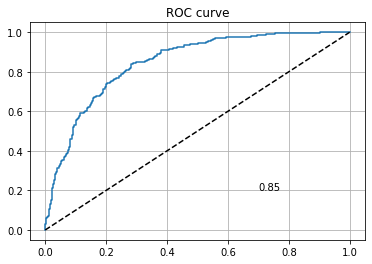

In [44]:
# ROC curve

plt.plot(fpr, tpr)
plt.grid()
plt.title("ROC curve")
plt.plot([0, 1], [0, 1], "k--")
plt.text(0.7, 0.2, np.round(roc_auc_score(y_train, y_scores),2 ))
plt.show()

In [45]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=200, 
                        learning_rate=0.1,
                        max_depth=5,
                        random_state=0)
xgb_clf.fit(X_train_tr, y_train)

# Cross-validation

cross_val_report(xgb_clf, X_train_tr, y_train)

Mean accuracy score is: 0.7469


# Refining the model

In [86]:
data_tr = data.copy()

In [87]:
# Replace 0s with NaN

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_tr[col] = data_tr[col].replace(0, np.nan)

In [88]:
data_tr

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [112]:
data_tr[data_tr["Glucose"].isna() & data_tr["Outcome"] == 1] = data_tr[data_tr["Outcome"] == 1]["Glucose"].median()

In [111]:
data_tr[data_tr["Outcome"] == 1]["Glucose"].median()

140.0

In [110]:
data_tr.loc[data_tr["Glucose"].isna() & data_tr["Outcome"] == 1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
349,5,NaN,80.0,32.0,NaN,41.0,0.346,37,1
502,6,NaN,68.0,41.0,NaN,39.0,0.727,41,1


In [113]:
data_tr[is_null]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,NaN,48.0,20.0,NaN,24.7,0.140,22,0
182,1,NaN,74.0,20.0,23.0,27.7,0.299,21,0
342,1,NaN,68.0,35.0,NaN,32.0,0.389,22,0
349,140,140.0,140.0,140.0,140.0,140.0,140.000,140,140
502,140,140.0,140.0,140.0,140.0,140.0,140.000,140,140
